# Notebook that generates my README

In [1]:
from datetime import datetime

import jinja2
import matplotlib.pyplot as plt
import mplcyberpunk

import generate_data as gd

plt.style.use("cyberpunk")

In [2]:
_ = await gd.generate_data()

2025-12-31 12:07:05,357 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/topocm/repos?type=sources "HTTP/1.1 200 OK"


2025-12-31 12:07:05,361 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/python-kasa/repos?type=sources "HTTP/1.1 200 OK"


2025-12-31 12:07:05,365 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/python-adaptive/repos?type=sources "HTTP/1.1 200 OK"


2025-12-31 12:07:05,427 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/pipefunc/repos?type=sources "HTTP/1.1 200 OK"


2025-12-31 12:07:05,566 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/kwant-project/repos?type=sources "HTTP/1.1 200 OK"


2025-12-31 12:07:05,686 INFO:httpx:HTTP Request: GET https://api.github.com/users/basnijholt/repos?type=sources "HTTP/1.1 200 OK"


2025-12-31 12:07:06,127 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=2 "HTTP/1.1 200 OK"


2025-12-31 12:07:06,624 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=3 "HTTP/1.1 200 OK"


2025-12-31 12:07:07,179 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=4 "HTTP/1.1 200 OK"


2025-12-31 12:07:07,682 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=5 "HTTP/1.1 200 OK"


2025-12-31 12:07:08,192 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=6 "HTTP/1.1 200 OK"


2025-12-31 12:07:08,719 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=7 "HTTP/1.1 200 OK"


2025-12-31 12:07:09,224 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=8 "HTTP/1.1 200 OK"


2025-12-31 12:07:09,709 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=9 "HTTP/1.1 200 OK"


2025-12-31 12:07:10,139 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=10 "HTTP/1.1 200 OK"


2025-12-31 12:07:10,659 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=11 "HTTP/1.1 200 OK"


2025-12-31 12:07:11,278 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=12 "HTTP/1.1 200 OK"


2025-12-31 12:07:12,146 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=13 "HTTP/1.1 200 OK"


2025-12-31 12:07:12,556 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=14 "HTTP/1.1 200 OK"


2025-12-31 12:07:12,728 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=15 "HTTP/1.1 200 OK"


2025-12-31 12:07:13,040 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:13,228 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:13,433 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:13,659 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:13,856 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:14,065 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:14,516 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:14,724 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:14,925 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:15,094 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:15,283 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:15,528 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:15,744 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:15,996 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:16,199 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:16,392 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:16,639 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:16,869 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:17,050 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:17,257 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:17,414 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:17,620 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:17,772 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:17,990 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:18,172 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:18,392 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:18,972 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:19,243 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:19,610 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:19,788 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:20,044 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:20,321 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:20,527 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:20,745 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:20,979 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:21,214 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:21,424 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:21,635 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:21,924 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:22,096 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:22,348 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:22,564 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:22,827 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:23,022 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:23,207 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:23,417 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:24,544 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:24,731 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:24,921 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:25,123 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:25,374 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:25,587 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:25,799 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:26,053 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:26,280 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:26,549 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:26,739 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:26,967 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:27,193 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:27,423 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:27,610 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:27,812 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:28,042 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:28,286 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:28,555 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:28,749 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:28,954 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:29,244 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:29,414 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:29,596 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:29,836 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:30,124 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:30,325 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:30,548 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:30,798 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:31,001 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:31,198 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:31,367 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:31,549 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:31,769 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:31,956 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:32,215 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:32,447 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:32,878 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:33,069 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:33,251 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:33,406 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:33,720 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:33,927 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:34,106 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:34,310 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:34,558 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:34,777 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:34,953 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:35,158 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:35,413 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:35,613 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:35,819 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:36,006 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:36,219 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:36,419 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:36,672 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:36,883 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:37,128 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:37,384 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:37,617 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:37,812 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:38,001 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:38,444 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:38,649 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:38,842 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:39,190 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:39,870 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:40,084 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:40,259 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:40,487 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:40,658 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:40,891 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:41,126 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:41,297 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:41,578 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:41,749 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:41,938 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:42,115 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:42,282 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:42,436 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:42,813 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:43,022 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:43,201 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:43,370 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:43,547 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:43,794 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:44,017 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:44,195 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-31 12:07:44,431 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


In [3]:
data = gd.load_data()
repos = data.repos
stargazers = data.stargazers

## Number of stars ⭐️

In [4]:
most_stars_strs = [
    f"{i+1}. [{repo['full_name']}](https://github.com/{repo['full_name']}/), {repo['stargazers_count']} ⭐️s"
    for i, repo in enumerate(stargazers[:20])
]

most_stars_strs_summary, most_stars_strs_rest = gd.split(most_stars_strs, 5)

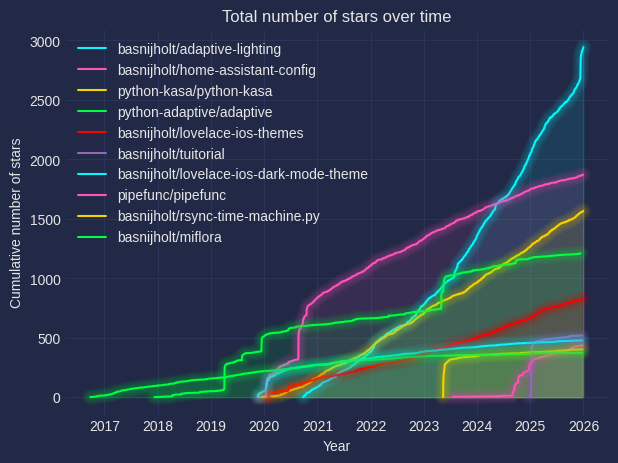

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative number of stars")
ax.set_title("Total number of stars over time")

for star_info in stargazers[:10]:
    dates = star_info["dates"]
    n_stars = list(range(1, len(dates) + 1))
    ax.plot(dates, n_stars, label=star_info["full_name"])
ax.legend()
mplcyberpunk.add_glow_effects()
plt.savefig("stars_over_time_per_repo.png")

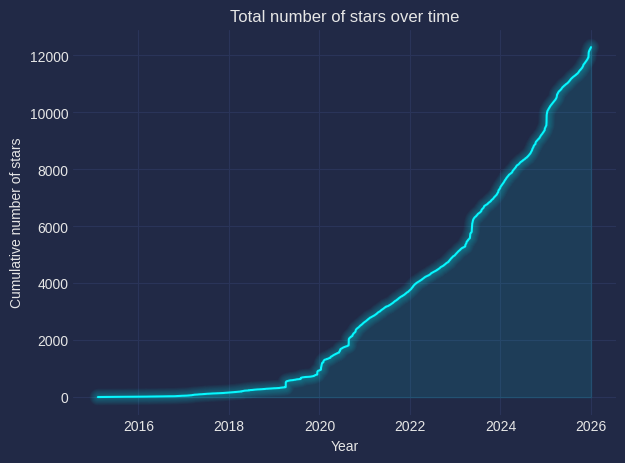

In [6]:
all_dates = sorted([date for star_info in stargazers for date in star_info["dates"]])
n_stars = list(range(1, len(all_dates) + 1))

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(all_dates, n_stars)
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative number of stars")
ax.set_title("Total number of stars over time")
mplcyberpunk.add_glow_effects()
plt.savefig("stars_over_time.png")

In [7]:
# gd.to_plotly_json()

# import plotly.graph_objs as go
# from plotly.subplots import make_subplots

# with open("data/traces_data.json", "r") as infile:
#     traces_data = json.load(infile)
# fig = make_subplots()
# for trace_data in traces_data:
#     trace = go.Scatter(**trace_data)
#     fig.add_trace(trace)
# fig.update_layout(
#     title="Cumulative number of stars over time",
#     xaxis_title="Date",
#     yaxis_title="Number of stars",
# )
# fig.show()


## Render template

In [8]:
with open("README.jinja2", "r") as f:
  template = f.read()
txt = jinja2.Template(template).render(
    most_stars_strs_summary=most_stars_strs_summary,
    most_stars_strs_rest=most_stars_strs_rest,
    now=str(datetime.now()),
)
with open("README.md", "w") as f:
    f.write(txt)
print(txt)

# Bas Nijholt 👋

<center>
  <table>
    <tr>
        <td><img width="300px" align="left" src="https://github-readme-stats.vercel.app/api/top-langs/?username=basnijholt&hide=TeX,Jupyter%20Notebook&layout=compact&theme=radical" /></td>
        <td><img align='right' src="https://github-readme-stats.vercel.app/api?username=basnijholt&show_icons=true&theme=radical" width="380"></td>
    </tr>
  </table>
</center>

- 👷🏻‍♂️ Currently at [IonQ](https://ionq.com/), doing my bit in building a quantum computer, before that I was at [Microsoft Quantum](https://quantum.microsoft.com/).
- 🌟 A deep dive into computational topological quantum mechanics earned me [my PhD](https://github.com/basnijholt/thesis).
- 🎨 I've crafted [a](https://github.com/basnijholt/adaptive-lighting) [few](https://github.com/basnijholt/aiokef) [libraries](https://github.com/basnijholt/miflora) for Home Assistant, making home automation a bit more fun.
- ⚒️ Made other tools [speed up](https://github.com/python-adaptive/adap